<a href="https://colab.research.google.com/github/dannytrees/swr/blob/master/Backtesting_A_Century_of_Profitable_Industry_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Century of Profitable Industry Trends

This code allows you to replicate the results presented in the paper "A Century of Profitable Industry Trends" published by ConcretumGroup founder, **Carlo Zarattini**.

Co-authored by **Mohamed Gabriel**.

For detailed explanations, please refer to the full blog post.

You can reach the authors of this code by email at [info@concretumgroup.com](mailto:info@concretumgroup.com).

More information can be found at [www.concretumgroup.com](http://www.concretumgroup.com).


0. Needed Libraries

In [ ]:
import os
import zipfile
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FuncFormatter,LogLocator
from statsmodels.api import OLS, add_constant

Step 1: Download and Process Industry Data

In [ ]:
# Define URLs for downloading data
INDUSTRY_PORTFOLIOS_URL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/48_Industry_Portfolios_daily_CSV.zip'
FRENCH_DATA_FACTORS_URL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
TEMP_FOLDER = 'temp_folder'

def download_and_extract_zip(url, extract_to=TEMP_FOLDER):
    """
    Downloads a ZIP file from a URL and extracts its contents.

    Args:
    url (str): The URL to download the ZIP file from.
    extract_to (str): The folder to extract the contents to.

    Returns:
    str: Path to the first CSV file found in the extracted contents.
    """
    zip_file = 'temp.zip'
    os.makedirs(extract_to, exist_ok=True)

    # Download the file
    with open(zip_file, 'wb') as f:
        f.write(requests.get(url).content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(zip_file)

    # Get the path to the extracted CSV file
    extracted_files = os.listdir(extract_to)
    csv_files = [f for f in extracted_files if f.lower().endswith('.csv')]

    if not csv_files:
        raise FileNotFoundError("No CSV file found in the extracted folder.")

    return os.path.join(extract_to, csv_files[0])

def cleanup_temp_files(folder=TEMP_FOLDER):
    """
    Removes temporary files and folder.

    Args:
    folder (str): The folder to clean up.
    """
    for f in os.listdir(folder):
        os.remove(os.path.join(folder, f))
    os.rmdir(folder)

def process_csv_file(csv_file_path):
    """
    Reads and processes the CSV file.

    Args:
    csv_file_path (str): Path to the CSV file.

    Returns:
    DataFrame: Processed data.
    DatetimeIndex: Dates.
    """
    csv_data = pd.read_csv(csv_file_path, skiprows=9, low_memory=False)
    csv_data = csv_data.apply(pd.to_numeric, errors='coerce')

    industry_names = csv_data.columns[1:]
    rows_nan = csv_data[csv_data.iloc[:, 0].isna()].index
    from_row = 0
    until_row = rows_nan[0]
    data = csv_data.iloc[from_row:until_row, :].to_numpy()

    ret = data[:, 1:] / 100
    caldt = pd.to_datetime(data[:, 0].astype(int).astype(str), format='%Y%m%d')
    ret[ret <= -0.99] = np.nan

    return pd.DataFrame(data=ret, index=caldt, columns=industry_names), caldt

def market_french_reconciled(caldt):
    """
    Reconciles market returns using Fama-French data.

    Args:
    caldt (DatetimeIndex): Dates.

    Returns:
    Series: Market returns.
    """
    csv_file_path = download_and_extract_zip(FRENCH_DATA_FACTORS_URL)
    csv_data = pd.read_csv(csv_file_path, skiprows=3, header=None, low_memory=False)

    # Coerce non-numeric data to NaN and then drop rows with NaN in the date column
    csv_data = csv_data.apply(pd.to_numeric, errors='coerce')
    csv_data = csv_data.dropna(subset=[0])  # Drop rows where the date column is NaN

    # Convert the first column to datetime
    caldt_mkt = pd.to_datetime(csv_data.iloc[:, 0].astype(int).astype(str), format='%Y%m%d')

    # Calculate market returns by adding Mkt-RF and RF and dividing by 100 to convert to decimal form
    ret_mkt = (csv_data.iloc[:, 1] + csv_data.iloc[:, 4]) / 100

    # Create a series filled with NaN values for the length of 'caldt'
    y = np.full(len(caldt), np.nan)

    # Find indices where dates match and assign values accordingly
    idx = np.where(np.in1d(caldt_mkt, caldt))[0]
    y[np.in1d(caldt, caldt_mkt)] = ret_mkt.iloc[idx]

    cleanup_temp_files()

    return pd.Series(data=y, index=caldt)

def tbill_french_reconciled(caldt):
    """
    Reconciles T-Bill returns using Fama-French data.

    Args:
    caldt (DatetimeIndex): Dates.

    Returns:
    Series: T-Bill returns.
    """
    csv_file_path = download_and_extract_zip(FRENCH_DATA_FACTORS_URL)
    csv_data = pd.read_csv(csv_file_path, skiprows=3, header=None, low_memory=False)

    # Coerce non-numeric data to NaN and then drop rows with NaN in the date column
    csv_data = csv_data.apply(pd.to_numeric, errors='coerce')
    csv_data = csv_data.dropna(subset=[0])  # Drop rows where the date column is NaN

    # Convert the first column to datetime
    caldt_tbill = pd.to_datetime(csv_data.iloc[:, 0].astype(int).astype(str), format='%Y%m%d')

    # Extract T-Bill returns and divide by 100 to convert to decimal form
    ret_tbill = csv_data.iloc[:, 4] / 100

    # Create a series filled with NaN values for the length of 'caldt'
    y = np.full(len(caldt), np.nan)

    # Find indices where dates match and assign values accordingly
    idx = np.where(np.in1d(caldt_tbill, caldt))[0]
    y[np.in1d(caldt, caldt_tbill)] = ret_tbill.iloc[idx]

    cleanup_temp_files()

    return pd.Series(data=y, index=caldt)

# Main code
csv_file_path = download_and_extract_zip(INDUSTRY_PORTFOLIOS_URL)
data, caldt = process_csv_file(csv_file_path)
cleanup_temp_files()

data['mkt_ret']   = market_french_reconciled(caldt)
data['tbill_ret'] = tbill_french_reconciled(caldt)

new_columns = [f'ret_{i+1}' for i in range(len(data.columns)-2)] + ['mkt_ret', 'tbill_ret']
data.columns = new_columns
data['caldt'] = caldt
data = data[['caldt'] + new_columns]
data.to_csv('industry48.csv', index=False)


Step 2: Process CSV Data for Indicators and Signals


In [ ]:
# Load the CSV data
data = pd.read_csv("industry48.csv")

# Convert `caldt` to datetime and set as index
data['caldt'] = pd.to_datetime(data['caldt'])
data.set_index('caldt', inplace=True)

# Determine the number of portfolios dynamically
num_portfolios = data.shape[1] - 2  # Subtracting 2 to account for 'mkt_ret' and 'tbill_ret'

# Indicator parameters
UP_DAY = 20
DOWN_DAY = 40
ADR_VOL_ADJ = 1.4  # ATR is usually 1.4x Vol(close2close)
KELT_MULT = 2 * ADR_VOL_ADJ

# Fill NaN values with 0 and calculate cumulative product
price = (1 + data.iloc[:, :num_portfolios].fillna(0)).cumprod()

# Define rolling functions
def rolling_vol(df, window):
    return df.rolling(window=window).std(ddof=0)

def rolling_ema(df, window):
    return df.ewm(span=window, adjust=False).mean()

def rolling_max(df, window):
    return df.rolling(window=window).max()

def rolling_min(df, window):
    return df.rolling(window=window).min()

def rolling_mean(df, window):
    return df.rolling(window=window, min_periods=window-1).mean()

# Calculate rolling volatility of daily returns
vol = rolling_vol(data.iloc[:, :num_portfolios], UP_DAY)

# Technical indicators
ema_down = rolling_ema(price, DOWN_DAY)
ema_up = rolling_ema(price, UP_DAY)

# Donchian channels
donc_up = rolling_max(price, UP_DAY)
donc_down = rolling_min(price, DOWN_DAY)

# Keltner bands
price_change = price.diff(periods=1).abs()
kelt_up = ema_up + KELT_MULT * rolling_mean(price_change, UP_DAY)
kelt_down = ema_down - KELT_MULT * rolling_mean(price_change, DOWN_DAY)

# Model bands
long_band = pd.DataFrame(np.minimum(donc_up.values, kelt_up.values), index=donc_up.index, columns=donc_up.columns)
short_band = pd.DataFrame(np.maximum(donc_down.values, kelt_down.values), index=donc_down.index, columns=donc_down.columns)

# Model long signal
long_band_shifted = long_band.shift(1)
short_band_shifted = short_band.shift(1)
long_signal = (price >= long_band_shifted) & (long_band_shifted > short_band_shifted)

# Create a dictionary of DataFrames for indicators
indicator_dfs = {
    f'ret_{i+1}': data.iloc[:, i] for i in range(num_portfolios)
}
indicator_dfs.update({
    f'price_{i+1}': price.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'vol_{i+1}': vol.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'ema_down_{i+1}': ema_down.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'ema_up_{i+1}': ema_up.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'donc_up_{i+1}': donc_up.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'donc_down_{i+1}': donc_down.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'kelt_up_{i+1}': kelt_up.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'kelt_down_{i+1}': kelt_down.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'long_band_{i+1}': long_band.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'short_band_{i+1}': short_band.iloc[:, i] for i in range(num_portfolios)
})
indicator_dfs.update({
    f'long_signal_{i+1}': long_signal.iloc[:, i] for i in range(num_portfolios)
})

# Concatenate all indicator columns into a single DataFrame
indicators_df = pd.concat(indicator_dfs.values(), axis=1)
indicators_df.columns = indicator_dfs.keys()

# Add market and tbill returns
indicators_df['mkt_ret'] = data['mkt_ret']
indicators_df['tbill_ret'] = data['tbill_ret']



Step 3: Backtesting the Strategy

In [ ]:
AUM_0 = 1
invest_cash = "YES"
target_vol = 0.015
max_leverage = 2
max_not_trade = 0.20

N_ind = num_portfolios  # Number of industries in the database
T = len(indicators_df['price_1'])  # Length of the time series

# Pre-allocate arrays with more specific initial values
exposure = np.zeros((T, N_ind))
ind_weight = np.zeros((T, N_ind))
trail_stop_long = np.full((T, N_ind), np.nan)

# Vectorized indicator data
rets = indicators_df[[f'ret_{j+1}' for j in range(N_ind)]].values
long_signals = indicators_df[[f'long_signal_{j+1}' for j in range(N_ind)]].values
long_bands = indicators_df[[f'long_band_{j+1}' for j in range(N_ind)]].values
short_bands = indicators_df[[f'short_band_{j+1}' for j in range(N_ind)]].values
prices = indicators_df[[f'price_{j+1}' for j in range(N_ind)]].values
vols = indicators_df[[f'vol_{j+1}' for j in range(N_ind)]].values

for t in range(1, T):
    valid_entries = ~np.isnan(rets[t]) & ~np.isnan(long_bands[t])

    prev_exposure = exposure[t - 1]
    current_exposure = exposure[t]
    current_trail_stop = trail_stop_long[t]
    current_long_signals = long_signals[t]
    current_short_bands = short_bands[t]
    current_prices = prices[t]
    current_vols = vols[t]

    new_long_condition = (prev_exposure <= 0) & (current_long_signals == 1)
    confirm_long_condition = (prev_exposure == 1) & (current_prices > np.maximum(trail_stop_long[t - 1], current_short_bands))
    exit_long_condition = (prev_exposure == 1) & (current_prices <= np.maximum(trail_stop_long[t - 1], current_short_bands))

    # Process new long positions
    new_longs = valid_entries & new_long_condition
    current_exposure[new_longs] = 1
    current_trail_stop[new_longs] = current_short_bands[new_longs]

    # Process confirmed long positions
    confirm_longs = valid_entries & confirm_long_condition
    current_exposure[confirm_longs] = 1
    current_trail_stop[confirm_longs] = np.maximum(trail_stop_long[t - 1, confirm_longs], current_short_bands[confirm_longs])

    # Process exit long positions
    exit_longs = valid_entries & exit_long_condition
    current_exposure[exit_longs] = 0
    ind_weight[t, exit_longs] = 0

    # Update leverage and weights for active long positions
    active_longs = current_exposure == 1
    lev_vol = np.divide(target_vol, current_vols, out=np.zeros_like(current_vols), where=current_vols != 0)
    ind_weight[t, active_longs] = lev_vol[active_longs]

# Update the indicators dataframe
# Collect new columns in a dictionary
new_columns = {}
for j in range(N_ind):
    new_columns[f'exposure_{j+1}'] = exposure[:, j]
    new_columns[f'ind_weight_{j+1}'] = ind_weight[:, j]
    new_columns[f'trail_stop_long_{j+1}'] = trail_stop_long[:, j]

# Convert the dictionary to a DataFrame and concatenate with the original DataFrame
new_columns_df = pd.DataFrame(new_columns, index=indicators_df.index)
indicators_df = pd.concat([indicators_df, new_columns_df], axis=1)


Step 4: Aggregate Portfolio Level Analysis

In [ ]:
# Initialize a DataFrame to store the results at the aggregate portfolio level
port = pd.DataFrame(index=indicators_df.index)
port['caldt'] = indicators_df.index
port['available'] = indicators_df.filter(like='ret_').notna().sum(axis=1)  # How many industries were available each day

ind_weight_df = indicators_df.filter(like='ind_weight_')
port_weights = ind_weight_df.div(port['available'], axis=0)

# Limit the exposure of each industry at "max_not_trade"
port_weights = port_weights.clip(upper=max_not_trade)

port['sum_exposure'] = port_weights.sum(axis=1)
idx_above_max_lev = port[port['sum_exposure'] > max_leverage].index

port_weights.loc[idx_above_max_lev] = port_weights.loc[idx_above_max_lev].div(
    port['sum_exposure'][idx_above_max_lev], axis=0
).mul(max_leverage)

port['sum_exposure'] = port_weights.sum(axis=1)

for i in range(N_ind):
    port[f'weight_{i+1}'] = port_weights.iloc[:, i]


ret_long_components = [
    port[f'weight_{i+1}'].shift(1).fillna(0) * indicators_df[f'ret_{i+1}'].fillna(0) for i in range(N_ind)
]
port['ret_long'] = sum(ret_long_components)

port['ret_tbill'] = (1 - port[[f'weight_{i+1}' for i in range(N_ind)]].shift(1).sum(axis=1)) * indicators_df['tbill_ret']

if invest_cash == "YES":
    port['ret_long'] += port['ret_tbill']

port['AUM'] = AUM_0 * (1 + port['ret_long']).cumprod()
port['AUM_SPX'] = AUM_0 * (1 + indicators_df['mkt_ret']).cumprod()


Step 5: Plotting the Portfolio AUM

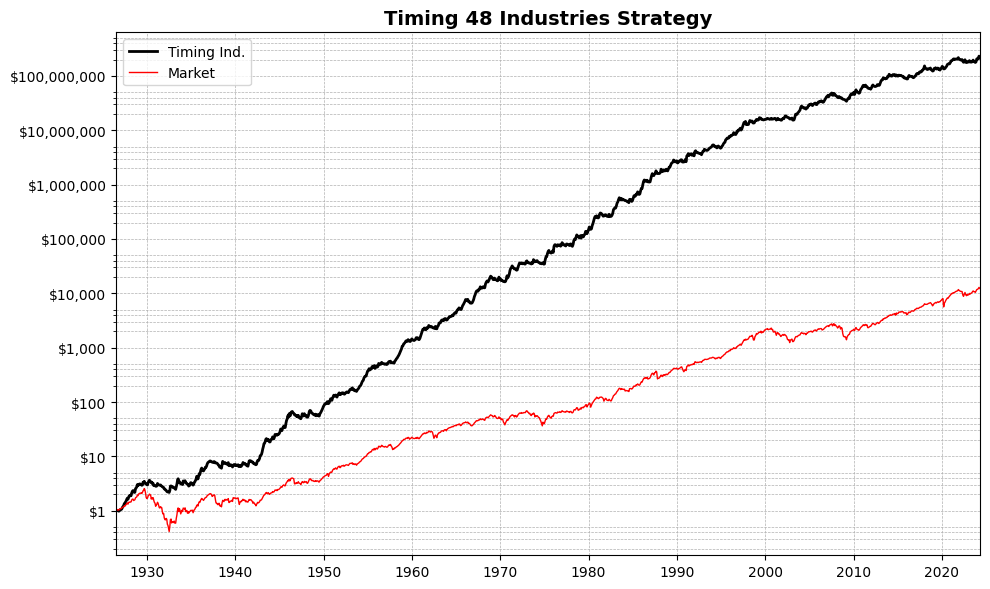

In [ ]:
# Ensure 'caldt' is in datetime format
port['caldt'] = pd.to_datetime(port['caldt'])

# Set the frequency for plotting
freq = 21

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the AUM
ax.plot(
    pd.concat([port['caldt'].iloc[::freq], port['caldt'].iloc[[-1]]]),
    pd.concat([port['AUM'].iloc[::freq], port['AUM'].iloc[[-1]]]),
    linewidth=2, color='k', label='Timing Ind.'
)

# Plot the AUM_SPX
ax.plot(
    pd.concat([port['caldt'].iloc[::freq], port['caldt'].iloc[[-1]]]),
    pd.concat([port['AUM_SPX'].iloc[::freq], port['AUM_SPX'].iloc[[-1]]]),
    linewidth=1, color='r', label='Market'
)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Set y-axis ticks to double each time
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[2, 3, 4, 5], numticks=10))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "${:,.0f}".format(x)))

# Ensure the y-axis labels are visible
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='y', which='minor', labelsize=8)

# Set x-axis date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(10))  # Show x-ticks every 10 years

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='upper left', fontsize=10)

# Set title
ax.set_title(f'Timing 48 Industries Strategy', fontweight='bold', fontsize=14)

# Set x and y limits
ax.set_xlim([port['caldt'].iloc[0], port['caldt'].iloc[-1]])

# Show the plot
plt.tight_layout()
plt.show()


Step 6: Statistical Analysis and Performance Metrics


In [ ]:
def compute_hit_ratio(returns, timeframe='daily'):
    if timeframe not in ['daily', 'monthly', 'yearly']:
        raise ValueError('Invalid timeframe. Choose "daily", "monthly", or "yearly".')

    if timeframe != 'daily':
        resample_rule = {'monthly': 'MS', 'yearly': 'YS'}[timeframe]
        returns = returns.resample(resample_rule).apply(lambda x: np.prod(1 + x) - 1)

    return round((returns > 0).mean() * 100, 0)

def compute_skewness(returns, timeframe='daily'):
    if timeframe not in ['daily', 'monthly', 'yearly']:
        raise ValueError('Invalid timeframe. Choose "daily", "monthly", or "yearly".')

    if timeframe != 'daily':
        resample_rule = {'monthly': 'MS', 'yearly': 'YS'}[timeframe]
        returns = returns.resample(resample_rule).apply(lambda x: np.prod(1 + x) - 1)

    return round(returns.skew(), 2)

def sortino_ratio(returns):
    downside_risk = returns[returns < 0].std()
    return returns.mean() / downside_risk

def max_drawdown(aum):
    cumulative = np.log1p(aum).cumsum()
    max_cumulative = cumulative.cummax()
    drawdown = np.expm1(cumulative - max_cumulative)
    return drawdown.min()

def table_of_stats(aum, n_assets, names, caldt, mkt_ret, tbill_ret):
    table_statistics = []

    for i in range(aum.shape[1]):
        ret = aum.iloc[:, i].pct_change(fill_method=None).fillna(0)  # Use fillna(0) to handle initial NA values
        strategy_stats = {
            'strategy': names[i],
            'assets': n_assets[i],
            'irr': round((np.prod(1 + ret) ** (252 / len(ret)) - 1) * 100, 1),
            'vol': round(ret.std() * np.sqrt(252) * 100, 1),
            'sr': round(ret.mean() / ret.std() * np.sqrt(252), 2),
            'sortino': round(sortino_ratio(ret) * np.sqrt(252), 2),
            'ir_d': compute_hit_ratio(ret, 'daily'),
            'ir_m': compute_hit_ratio(ret, 'monthly'),
            'ir_y': compute_hit_ratio(ret, 'yearly'),
            'skew_d': round(ret.skew(), 2),
            'skew_m': compute_skewness(ret, 'monthly'),
            'skew_y': compute_skewness(ret, 'yearly'),
            'mdd': round(max_drawdown(aum.iloc[:, i]) * 100, 0),
        }

        # Regression using statsmodels
        X = (mkt_ret - tbill_ret).values
        Y = (ret - tbill_ret).values
        valid_idx = ~np.isnan(Y)
        X = add_constant(X[valid_idx])
        Y = Y[valid_idx]
        model = OLS(Y, X).fit()
        intercept, coef = model.params

        strategy_stats['alpha'] = round(intercept * 100 * 252, 2)
        strategy_stats['beta'] = round(coef, 2)
        strategy_stats['worst_ret'] = round(ret.min() * 100, 2)
        strategy_stats['worst_day'] = caldt[ret.idxmin()].strftime('%Y-%m-%d')
        strategy_stats['best_ret'] = round(ret.max() * 100, 2)
        strategy_stats['best_day'] = caldt[ret.idxmax()].strftime('%Y-%m-%d')

        table_statistics.append(strategy_stats)

    return pd.DataFrame(table_statistics)

# Calculate statistics for the portfolio and market
table_statistics = table_of_stats(
    port[['AUM', 'AUM_SPX']],
    [len(port.columns) - 2, 1],
    ["Timing Ind.", "Market"],
    port['caldt'],
    indicators_df['mkt_ret'],
    indicators_df['tbill_ret']
)


table_statistics.set_index('strategy', inplace=True)
table_statistics = table_statistics.transpose()
table_statistics

strategy,Timing Ind.,Market
assets,53,1
irr,20.7,9.7
vol,15.3,17.1
sr,1.3,0.63
sortino,1.58,0.77
ir_d,58.0,55.0
ir_m,56.0,63.0
ir_y,82.0,76.0
skew_d,-0.71,-0.17
skew_m,0.69,0.14
